# Random forest
In the following we use the Random Forest method on the converted data from the descriptive_analysis.ipynb

Source Random Forest Model: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0 
Linear Regresseion Model: https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f
Source Kfold Cross Validation on Random Forests: https://www.youtube.com/watch?v=gJo0uNL-5Qw 
Tuning Hyperparameters with GridSearch: https://www.youtube.com/watch?v=HdlDYng8g9s
Sckit learn: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

The following Python code loads in the csv data and displays the structure of the data: 

# Imported libraries

In [509]:
import pandas as pd
import numpy as np
# matplotlib for plotting 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as seabornInstance 
# metrics used for calculating the different mean errors
from sklearn import metrics
# Import tools needed for visualization
from sklearn.tree import export_graphviz 
import pydot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
import datetime as dt
from datetime import datetime, timedelta
from sklearn import preprocessing

In [510]:
# Read in data, set index to column 0, parse dates and display first 5 rows
test = pd.read_csv('./data/converted_test_2020_07_17_12-15-40.csv', index_col=0, parse_dates=['Flight_Date','Request_Date'])

train = pd.read_csv('./data/converted_train_2020_07_17_12-15-40.csv', index_col=0, parse_dates=['Flight_Date','Request_Date'])
train.head(5)

,Request_Date,Flight_Date,Duration_Time,Departure_hour,flight_unique_id,route_abb,flight_number,Price,Currency,min_future_price,...,min_future_price_in_eur,Request_Weekday,Request_timeofday,Departure_timeofday,flight_distance_km,Request_hour,Request_Date_Month,Flight_Date_Month,route_abb_from,route_abb_to
0,2019-06-03 11:00:00,2019-06-05 19:00:00,56.0,19,2019-06-05 FR 146,SXF-STN,FR 146,208.07,€,259.07,...,259.070000,Monday,Morning,Evening,907.2,11,6,6,SXF,STN
1,2019-06-03 23:00:00,2019-06-05 19:00:00,44.0,19,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,...,259.070000,Monday,Night,Evening,907.2,23,6,6,SXF,STN
2,2019-06-04 11:00:00,2019-06-05 19:00:00,32.0,19,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,...,259.070000,Tuesday,Morning,Evening,907.2,11,6,6,SXF,STN
3,2019-06-04 23:00:00,2019-06-05 19:00:00,20.0,19,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,...,259.070000,Tuesday,Night,Evening,907.2,23,6,6,SXF,STN
4,2019-06-03 11:00:00,2019-06-05 21:00:00,58.0,21,2019-06-05 FR 147,STN-SXF,FR 147,127.49,£,223.37,...,252.059401,Monday,Morning,Night,907.2,11,6,6,STN,SXF


In [511]:
# Show how many entries and columns, and if there are null-values and show the data types 
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83624 entries, 0 to 83623
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Request_Date             83624 non-null  datetime64[ns]
 1   Flight_Date              83624 non-null  datetime64[ns]
 2   Duration_Time            83624 non-null  float64       
 3   Departure_hour           83624 non-null  int64         
 4   flight_unique_id         83624 non-null  object        
 5   route_abb                83624 non-null  object        
 6   flight_number            83624 non-null  object        
 7   Price                    83624 non-null  float64       
 8   Currency                 83624 non-null  object        
 9   min_future_price         83624 non-null  float64       
 10  price_in_eur             83624 non-null  float64       
 11  min_future_price_in_eur  83624 non-null  float64       
 12  Request_Weekday          83624 n

In [512]:
print('The shape of our features is:', train.shape)

The shape of our features is: (83624, 21)


We notice that we have 83.624 rows and 21 columns with 20 features. We have no missing date or null values in our data set. 
To identify any anomalies we compute the summary statistics and make some plots. 

In [513]:
# Descriptive statistics for each column
round(train.describe(), 2)

,Duration_Time,Departure_hour,Price,min_future_price,price_in_eur,min_future_price_in_eur,flight_distance_km,Request_hour,Request_Date_Month,Flight_Date_Month
count,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00
mean,929.92,12.97,68.16,53.70,71.95,56.70,805.25,16.98,6.46,7.71
std,548.57,6.18,51.93,43.79,54.78,46.16,137.93,6.00,0.55,0.83
min,19.00,6.00,8.99,8.99,8.99,8.99,618.63,11.00,6.00,6.00
25%,475.00,7.00,30.33,19.99,32.76,22.37,618.63,11.00,6.00,7.00
50%,883.00,10.00,52.01,39.46,55.07,42.06,907.20,11.00,6.00,8.00
75%,1328.00,19.00,88.73,73.43,91.79,73.43,907.20,23.00,7.00,8.00
max,2375.00,22.00,334.87,311.09,372.96,311.09,907.20,23.00,8.00,9.00


There are not any data points immediately appear as anomalous and no zeros in any of the measurement columns. 

# Data preparation
We will now do some minor modifications to put our data into machine-understandable terms. We will use the Python library Pandas for the data manipulation relying on the structure known as dataframe.

The first step is the one-hot-encoding of the data. This process takes categorical variables, such as days of the week and converts it to a numerical representation without an arbitrary ordering.

In [514]:
# One Hot encoding for categorical values
train = pd.get_dummies(train, columns=['Request_Weekday', 'Request_timeofday', 'Departure_timeofday', 'route_abb_from', 'route_abb_to', 'Departure_hour'])
test = pd.get_dummies(test, columns=['Request_Weekday', 'Request_timeofday', 'Departure_timeofday', 'route_abb_from', 'route_abb_to', 'Departure_hour'])

In [515]:
# Add train column
test['training'] = 0
train['training'] = 1

# Equal columns across both tables
combined = pd.concat([train,test], sort=False)
train = combined[combined['training'] == 1]
test = combined[combined['training'] == 0]

# Fill NaN with 0
train = train.fillna(0)
test = test.fillna(0)

# Drop train column
test.drop(['training'], axis=1, inplace=True)
train.drop(['training'], axis=1, inplace=True)

In [516]:
# we tranform the data 
trainFeatures = [['min_future_price_in_eur', 'Duration_Time', 'price_in_eur', 'flight_distance_km']]
for feature in trainFeatures:
    train[feature] = np.log1p(train[feature])

    
testFeatures = [['Duration_Time', 'price_in_eur', 'flight_distance_km']]
for feature in testFeatures:
    test[feature] = np.log1p(test[feature])

Now we drop the columns in the train and test date which we do not need for our model. 

In [517]:
# Drop columns we do not need from train
train = train.drop(columns=['route_abb', 'min_future_price', 'Currency', 'flight_unique_id', 'Price', 'Request_Date', 'Flight_Date', 'Request_Date_Month', 'Flight_Date_Month', 'Request_hour', 'flight_number'])

# Drop columns we do not need from test
test_drop = test.drop(columns=['route_abb', 'min_future_price', 'Currency', 'flight_unique_id', 'Price', 'min_future_price', 'min_future_price_in_eur', 'Request_Date', 'Flight_Date', 'Request_Date_Month', 'Flight_Date_Month', 'Request_hour', 'flight_number'])

In [518]:
# Descriptive statistics for each column
round(train.describe(), 2)

,Duration_Time,price_in_eur,min_future_price_in_eur,flight_distance_km,Request_Weekday_Friday,Request_Weekday_Monday,Request_Weekday_Saturday,Request_Weekday_Sunday,Request_Weekday_Thursday,Request_Weekday_Tuesday,...,route_abb_to_SXF,Departure_hour_6,Departure_hour_7,Departure_hour_8,Departure_hour_9,Departure_hour_10,Departure_hour_18,Departure_hour_19,Departure_hour_21,Departure_hour_22
count,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00,...,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00,83624.00
mean,6.59,4.04,3.79,6.68,0.14,0.15,0.14,0.13,0.14,0.15,...,0.32,0.21,0.18,0.05,0.00,0.08,0.15,0.24,0.01,0.08
std,0.81,0.70,0.73,0.18,0.35,0.36,0.34,0.34,0.35,0.36,...,0.47,0.41,0.38,0.22,0.03,0.27,0.36,0.43,0.10,0.27
min,3.00,2.30,2.30,6.43,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,6.17,3.52,3.15,6.43,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,6.78,4.03,3.76,6.81,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,7.19,4.53,4.31,6.81,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,7.77,5.92,5.74,6.81,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In the next step we separate the data into the features and targets. The target, also known as the label, is the value we want to predict, in this case the min_future_price and the features are all the columns the model uses to make a prediction. We will also convert the Pandas dataframes to Numpy arrays because that is the way the algorithm works. 

In [519]:
# Use numpy to convert the Pandas dataframes to arrays
# y is the value or label we want to predict
y = np.array(train['min_future_price_in_eur'])

# Remove the label from the features
# axis 1 refers to the columns
X = train.drop('min_future_price_in_eur', axis = 1)

# Saving feature names
feature_list_1 = list(X.columns)

# Convert to numpy array
#X = np.array(X)

# Feature importance
In order to quantify the usefulness of all the variables in the entire random forest, we can look at the relative importances of the variables. The importances returned in Skicit-learn represent how much including a particular variable improves the prediction. 

In [520]:
# Features with the highest absolute coef_ value are considered the most important
feature_names = X.columns
clf = LassoCV(cv=100).fit(X, y)
print(clf.score(X, y))
importance = np.abs(clf.coef_)
print(importance)

0.8624987133561871
[1.71433116e-01 8.26672501e-01 0.00000000e+00 2.42579394e-02
 1.08496877e-02 8.41869757e-03 9.41397849e-03 1.23956749e-02
 0.00000000e+00 0.00000000e+00 4.60710603e-03 1.66881496e-16
 2.18842475e-02 0.00000000e+00 0.00000000e+00 3.37966837e-02
 8.94666279e-03 0.00000000e+00 0.00000000e+00 2.20986130e-17
 3.11123235e-02 1.13804303e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.64028556e-02 5.35796432e-02 0.00000000e+00
 0.00000000e+00 1.58370878e-02]


In [521]:
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01

idx_features = (-importance).argsort()[:4]
name_features = np.array(feature_names)[idx_features]
print('Selected features: {}'.format(name_features))

sfm = SelectFromModel(clf, threshold=threshold)
sfm.fit(X, y)
X_transform = sfm.transform(X)

n_features = sfm.transform(X).shape[1]

Selected features: ['price_in_eur' 'Duration_Time' 'Departure_hour_18' 'Departure_hour_10']


In [522]:
features = name_features
X = X[features]

In [523]:
# Saving feature names for later use for visualizations
feature_list = list(X.columns)
# Convert to numpy array
X = np.array(X)

# Splitting data into training and testing sets
During training, we let the model ‘see’ the answers, in this case the min_future_price_inr_eur, so it can learn how to predict the price from the features. 
We split 80% of the data to the training set and 20% to the testing set. We set the random state to 42 which means the results will be the same each time I run the split for reproducible results.

In [524]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

We look at the shape of all the data to make sure we did everything correctly. The training features number of columns match the testing feature number of columns and the number of rows match for the respective training and testing features and the labels:

In [525]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (66899, 4)
Training Labels Shape: (66899,)
Testing Features Shape: (16725, 4)
Testing Labels Shape: (16725,)


# Build and train the model
After splitting the data into training and testing set, we can train the algorithm. For that we instantiate the Random Forest Regressor with 80 trees and a random state of 42. We call the fit method along with the training data. 

In [526]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 60 decision trees
rf_reg = RandomForestRegressor(n_estimators = 80, random_state = 42)

# Train the model on training data
rf_model = rf_reg.fit(X_train, y_train)

To see which parameters are used by our Random Forest we print them out. We use Bootstrapping, which is a statistical resampling technique that involves random sampling of a dataset with replacement. Our criterion is the Mean Squared Error.

In [527]:
from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_reg.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 80,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


# Make Predictions on the model
Now that we have trained our algorithm, we can make some predictions. Therefore we use the test features and see how accurately the algorithm predict the min future price. 
When performing regression, we need to make sure to use the absolute error because we expect some of our answers to be low and some to be high. We are interested in how far away our average prediction is from the actual value so we take the absolute value.
We compare the actual output values for X_test with the predicted values. 
We also visualize the comparison result as a bar graph and we take 25 records for the visualization. 

In [528]:
# Use the forest's predict method on the test data
y_pred = rf_reg.predict(X_test)

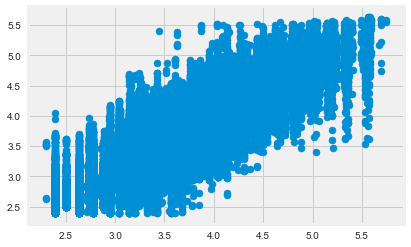

In [417]:
# Make cross validated predictions
predictions = cross_val_predict(rf_model, X, y, cv=6)
plt.scatter(y, predictions)

In [529]:
# compare actual output values with the predicted values
df = round(pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()}), 2)
df

,Actual,Predicted
0,3.56,4.04
1,3.85,3.94
2,3.70,3.73
3,4.50,4.50
4,3.95,4.03
...,...,...
16720,3.18,3.15
16721,3.75,3.30
16722,4.67,4.68
16723,3.59,3.57


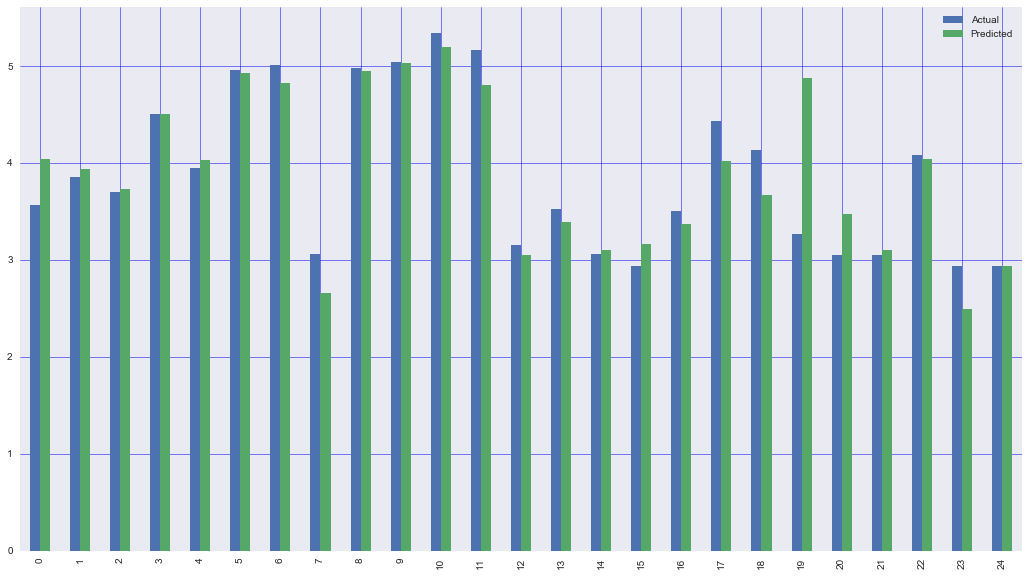

In [530]:
# Set the style
plt.style.use('seaborn')

# plot 25 records where the price is shown on the y-axes and the number of record on the x-axes
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='blue')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Our model is not very precise, but the predicted percentages are close to the actual ones. 

# Evaluation of the model 
We evaluate the performance of the algorithm. For regression algorithms, three evaluation metrics are commonly used. Mean Absolute Error (MAE), Mean Squared Error (MSE) and the Root Mean Squared Error (RMSE). For these metrics we are using the test data. 

In [531]:
# Return the mean accuracy on the given test data and labels
print('Score:', rf_reg.score(X_test, y_test))

# Return the mean accuracy on the given test data and labels with cross validation 
scores = cross_val_score(rf_model, X, y, cv=6)
print('Cross-validated scores:', scores)

Score: 0.8785785942455642
Cross-validated scores: [0.743253   0.82655869 0.81174177 0.71977672 0.70691638 0.70893395]


With our model we have a mean accuracy of 87.9%. With Cross Validation we have a worse result where 82,7% is the highest. 

In [532]:
# Calculate the absolute errors
errors = abs(y_pred - y_test)

# Print out the mean absolute error (MAE)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Print out the mean squared error (MSE)
print('Mean Squared Error:', round(np.square(errors).mean(), 2))  

# Print out the root mean squared error (RMSE)
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 2))

Mean Absolute Error: 0.18
Mean Squared Error: 0.06
Root Mean Squared Error: 0.25


In [533]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%')

Accuracy: 95.18 %


Our model has learned how to predict the min future price for a flight with 95.18% accuracy. 

# Improve the model 
First we will look at a single tree in the forest, and second, we look at the feature importances. 

In [236]:
# Pull out one tree from the forest
#tree = rf_reg.estimators_[5]

# Export the image to a dot file
#export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
#graph.write_png('tree.png')

In [534]:
# The following code takes one tree from the forest and saves it as an image.
# Limit depth of tree to 3 levels
rf_reg_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_reg_small.fit(X_train, y_train)

# Extract the small tree
tree_small = rf_reg_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = features, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

Based solely on this tree, we can make a prediction for any new data point. An interesting observation is that in the root node, there are only 42.271 samples despite there being 66.899 training data points. This is because each tree in the forest is trained on a random subset of the data points with replacement (We can turn off the sampling with replacement and use all the data points by setting bootstrap = False when making the forest).

Furthermore, we see that in our tree, there is only one variable we actually used to make a prediction. The only important information according to our simple tree is the price_in_eur and the duration time. 

We can look at the features again and take the two most important from them. 

In [535]:
# Get numerical feature importances
importances = list(rf_reg.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: price_in_eur         Importance: 0.9061
Variable: Duration_Time        Importance: 0.0844
Variable: Departure_hour_18    Importance: 0.0055
Variable: Departure_hour_10    Importance: 0.004


A simple bar plot of the feature importances to illustrate the disparities in the relative significance of the variables.
Next, we plot the entire dataset with predictions highlighted. We can use this plot to determine if there are any outliers in either the data or our predictions.

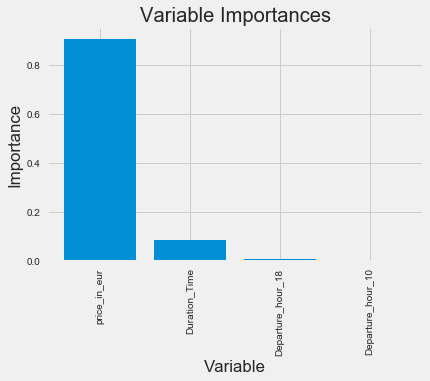

In [536]:
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

At the top of the list is price_in_eur, the price of the flight on the requested date. This tells us the best predictor of the min_future_price is the requested flight price.

The second most important factor is the duration time between request and flight date.

In future implementations of the model, we can remove those variables that have no importance and the performance will not suffer. Let’s make a random forest with only the two most important variables, the price_in_eur and the duration_time and see how the performance compares.

# Hyperparameter tuning 
The score of the model is changed by its samples. For that reason we use the random hyperparameter grid to find the best parameters for the best performance.

In [537]:
model_params = {
    'random_forest':{
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 60, 80]
        }
    }
}

In [538]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [539]:
hyper = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
hyper

,model,best_score,best_params
0,random_forest,0.744134,{'n_estimators': 60}


We receive the best score if we set the estimator to 60 trees. 

In [540]:
# using cross validation score with different estimator values 
cross_val_score(RandomForestRegressor(n_estimators=90), X, y)

array([0.71953518, 0.82599028, 0.75082709, 0.72436451, 0.70189166])

In [430]:
# using cross validation score with different estimator values 
cross_val_score(RandomForestRegressor(n_estimators=100), X, y)

array([0.72233508, 0.82600063, 0.74869079, 0.73182271, 0.71819845])

With cross validation we received a better score with 100 trees. Now we build a new random forest with 100 trees and only 2 variables, the price_in_eur and the duration time. 

In [541]:
# New random forest with only the two most important variables
rf_reg_most_important = RandomForestRegressor(n_estimators= 100, random_state=42)

# Extract the most important features
important_indices = [feature_list.index('price_in_eur'), feature_list.index('Duration_Time')]
train_important = X_train[:, important_indices]
test_important = X_test[:, important_indices]

# Train the random forest
rf_reg_most_important.fit(train_important, y_train)

# Make predictions and determine the error
predictions = rf_reg_most_important.predict(test_important)
errors = abs(predictions - y_test)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%')

# Print out the mean squared error (MSE)
print('Mean Squared Error:', round(np.square(errors).mean(), 2))  

Mean Absolute Error: 0.19
Accuracy: 94.87 %
Mean Squared Error: 0.07


The percentage of accuracy doesn't changed a lot. This tells us that we do not need all the data we collected to make accurate predictions. 

At this point we have created a random forest model for a supervised regression problem. We can feel confident that our model can predict the min future price of a flight with 94.87% accuracy.

# Use on Test Data

In [542]:
test_prediction = rf_reg.predict(np.array(test_drop[features]))

In [543]:
final_prediction = pd.DataFrame({'Request_Date': test['Request_Date'], 'flight_unique_id': test['flight_unique_id'], 'price_in_eur': np.exp(test['price_in_eur']), 'min_future_price_eur': np.exp(test_prediction)})
final_prediction

,Request_Date,flight_unique_id,price_in_eur,min_future_price_eur
0,2019-06-03 11:00:00,2019-07-02 FR 145,31.321154,21.406229
1,2019-06-03 23:00:00,2019-07-02 FR 145,45.528200,29.494478
2,2019-06-04 11:00:00,2019-07-02 FR 145,45.467984,37.338415
3,2019-06-04 23:00:00,2019-07-02 FR 145,45.467984,35.303756
4,2019-06-05 11:00:00,2019-07-02 FR 145,45.521668,27.600037
...,...,...,...,...
5578,2019-07-30 23:00:00,2019-08-02 FR 8545,43.830000,51.879163
5579,2019-07-31 11:00:00,2019-08-02 FR 8545,51.990000,73.247051
5580,2019-07-31 23:00:00,2019-08-02 FR 8545,51.990000,53.763015
5581,2019-08-01 11:00:00,2019-08-02 FR 8545,51.990000,51.990000


# Compute Buy False/ True
Binary encoding of buy or wait for the price to drop. If min_future_price > price = buy (1) | min_future_price < price = wait (0)

In [545]:
final_prediction['buy'] = np.nan
for index, row in final_prediction.iterrows():
    if row.price_in_eur > row.min_future_price_eur:
        final_prediction.at[index,'buy']=0
    else:
        final_prediction.at[index,'buy']=1
print(final_prediction)
final_prediction.to_csv('./data/random_forest_test.csv', sep=',')

            Request_Date    flight_unique_id  price_in_eur  \
0    2019-06-03 11:00:00   2019-07-02 FR 145     31.321154   
1    2019-06-03 23:00:00   2019-07-02 FR 145     45.528200   
2    2019-06-04 11:00:00   2019-07-02 FR 145     45.467984   
3    2019-06-04 23:00:00   2019-07-02 FR 145     45.467984   
4    2019-06-05 11:00:00   2019-07-02 FR 145     45.521668   
...                  ...                 ...           ...   
5578 2019-07-30 23:00:00  2019-08-02 FR 8545     43.830000   
5579 2019-07-31 11:00:00  2019-08-02 FR 8545     51.990000   
5580 2019-07-31 23:00:00  2019-08-02 FR 8545     51.990000   
5581 2019-08-01 11:00:00  2019-08-02 FR 8545     51.990000   
5582 2019-08-01 23:00:00  2019-08-02 FR 8545     51.990000   

      min_future_price_eur  buy  
0                21.406229  0.0  
1                29.494478  0.0  
2                37.338415  0.0  
3                35.303756  0.0  
4                27.600037  0.0  
...                    ...  ...  
5578             

# Optimization Performance 
From moodle page: Das Vorhersagemodell für die Entscheidung Warten oder Kaufen eines Flugtickets soll hinsichtlich der Vorhersagegenauigkeit optimiert werden, d.h. Genauigkeit = Anzahl der richtigen Entscheidungen / Anzahl aller Entscheidungen.

In [546]:
optimize_final_prediction = final_prediction
def getModelScore(data):
    data['Request_Date'] = pd.to_datetime(data['Request_Date'], format='%Y-%m-%d %H:%M:%S')
    decision_true_total = 0
    unique_flights_id = data['flight_unique_id'].unique()
    for element in unique_flights_id:
        flights = data[data['flight_unique_id'] == element].sort_values('Request_Date', ascending=False)
        for index, flight in flights.iterrows():
            filtered_flights = flights[flights['Request_Date'] >= flight.Request_Date].sort_values('Request_Date', ascending=False)
            if flight.buy == 1:
                filtered_flights = filtered_flights[filtered_flights['price_in_eur'] < flight.price_in_eur]
            if flight.buy == 0:
                filtered_flights = filtered_flights[filtered_flights['price_in_eur'] > flight.price_in_eur]
            if len(filtered_flights) == 0:
                decision_true_total = decision_true_total + 1
    print('True: ' + str(decision_true_total))
    print('Total: ' + str(len(data)))
    return decision_true_total/len(data)

getModelScore(optimize_final_prediction)
# Standard Scaler = 1264 ['price_in_eur' 'Duration_Time']
# Robust Scaler = 1280
# MinMaxScaler = 742
# PowerTransformer = 1257

True: 732
Total: 5583


0.13111230521225148

In [547]:
# Get the next best price from the test data set.
check_final_prediction = final_prediction
def checkDateToBuy(data, flight_unique_id, request_date):
    flights = data[data['flight_unique_id'] == flight_unique_id].sort_values('Request_Date', ascending=False)
    price_saving = 0
    if request_date <= flights.iloc[0].Request_Date:
        flights['Request_Date'] = pd.to_datetime(flights['Request_Date'], format='%Y-%m-%d %H:%M:%S')
        flights = flights[flights['Request_Date'] > request_date].sort_values('Request_Date', ascending=True)
        initialPrice = 0
        flights = flights.reset_index()
        for index, flight in flights.iterrows():
            if index == 0:
                initialPrice = flight.price_in_eur
            if flight.buy == 1:
                price_saving = initialPrice - flight.price_in_eur
                return [request_date, price_saving, flight.Request_Date]
        return 0
    else:
        print('No data available for the supplied Request_Date')

checkDateToBuy(check_final_prediction, '2019-07-02 FR 145', datetime(2019, 5, 1))

[datetime.datetime(2019, 5, 1, 0, 0),
 -4.812003200890917,
 Timestamp('2019-06-12 11:00:00')]